In [1]:
!nvidia-smi

Mon Mar 29 12:25:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# auxillary downloads

In [2]:
!pip install -q timm

# Libraries 

In [3]:
import pandas as pd
import numpy as np
import os 
import random 
import torch 
import torch.nn as nn
import torch.nn.functional as f 
from torch.utils.data import Dataset , DataLoader
from torchvision import models, transforms
from glob import glob 
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score , roc_auc_score , f1_score,precision_score,recall_score
from sklearn.model_selection import StratifiedKFold , GroupKFold , KFold

import imageio
import cv2
import albumentations as a
from tqdm.notebook import tqdm

from sklearn.utils import shuffle
from torch.autograd import Function
import timm
import time
import warnings
import gc 
warnings.filterwarnings("ignore")

# Config

In [4]:
cfg = {
    'seed':2021,
    'test_bs':16,
    'tta':False,
    'num_workers':4,
    'image_size':256,
    'backbone':'resnet200d'
    
}
device = ('cuda' if torch.cuda.is_available() else 'cpu')

# Test data prepration

In [8]:
covid_images1 = glob('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/*')
covid_images2 = glob('../input/covid-19-x-ray-10000-images/dataset/covid/*')
covid_images = covid_images1+covid_images2
#covid_images = covid_images[0:80]
covid_df = pd.DataFrame()
covid_df['Path'] = covid_images
covid_df['Class'] = 'Covid'
covid_df['Targets'] = 0



pneumonia_images1 = glob('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/*')
pneumonia_images2 = glob('../input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PNEUMONIA/*')
pneumonia_images3 = glob('../input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/train/PNEUMONIA/*')
pneumonia_images = pneumonia_images1+pneumonia_images2+pneumonia_images3
#pneumonia_images = pneumonia_images[:75]
pne_df = pd.DataFrame()
pne_df['Path'] = pneumonia_images 
pne_df['Class'] = 'Pneumonia'
pne_df['Targets'] = 1

normal_images1 = glob('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/*')
normal_images2 = glob('../input/covid-19-x-ray-10000-images/dataset/normal/*')
normal_images3 = glob('../input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/NORMAL/*')
normal_images4 = glob('../input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/train/NORMAL/*')
normal_images = normal_images1 + normal_images2 + normal_images3 + normal_images4
#normal_images = normal_images[0:80]
normal_df = pd.DataFrame()
normal_df['Path'] = normal_images
normal_df['Class'] = 'Normal'
normal_df['Targets'] = 2
data = pd.concat([covid_df,pne_df,normal_df],axis=0).reset_index(drop =  True)
data = shuffle(data).reset_index(drop = True)
data

,Path,Class,Targets
0,../input/covid19-radiography-database/COVID-19...,Covid,0
1,../input/covid19-radiography-database/COVID-19...,Normal,2
2,../input/covid19-radiography-database/COVID-19...,Normal,2
3,../input/covid19-radiography-database/COVID-19...,Covid,0
4,../input/covid19-radiography-database/COVID-19...,Normal,2
...,...,...,...
15434,../input/covid19-radiography-database/COVID-19...,Normal,2
15435,../input/covid19-radiography-database/COVID-19...,Normal,2
15436,../input/covid19-radiography-database/COVID-19...,Covid,0
15437,../input/covid19-radiography-database/COVID-19...,Covid,0


In [9]:
#data = data.iloc[90:100,:].reset_index(drop = True)
#data

# Seeding 

In [10]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(cfg['seed'])

# Augmentations 

In [11]:
test_augs = a.Compose([
    a.Resize(cfg['image_size'],cfg['image_size']),
    a.Normalize()
])

# test dataset

In [12]:
class test_dataset(Dataset):
    def __init__(self,df,augmentations = None):
        super().__init__()
        self.df = df
        self.aug = augmentations 
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self,idx):
        img_path = self.df['Path'][idx]
        label = self.df['Targets'][idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.aug is not None:
            res = self.aug(image = img)
            img = res['image']
        img = img.astype(np.float32)
        img = img.transpose(2,0,1)
    
        return img , label

# test dataloader 

In [13]:
def test_dataloader(df):
    dataset = test_dataset(df,augmentations = test_augs)
    test_loader = DataLoader(dataset,num_workers = cfg['num_workers'],shuffle = False,
                            batch_size = cfg['test_bs'],pin_memory = False)
    
    return test_loader

# inference function 

In [14]:
def inference(test_loader,model,loss_fun,device):
    model.eval()
    t = time.time()
    accuracy = 0.0
    loss = 0.0
    auc = 0.0
    f1 = 0.0
    recall = 0.0
    precision = 0.0
    losses = []
    image_preds_all = []
    image_targets_all = []
    pbar = tqdm(enumerate(test_loader),total = len(test_loader))
    for step , (images,labels) in pbar:
        images , labels = images.to(device,dtype = torch.float32) , labels.to(device,dtype = torch.long)
        PREDS = []
        TARGETS = []
        with torch.no_grad():
            logits = model (images)
            image_preds_all += [torch.argmax(logits, 1).detach().cpu().numpy()]
            image_targets_all += [labels.detach().cpu().numpy()]
            PREDS.append(logits.detach().cpu().numpy())
            TARGETS.append(labels.detach().cpu().numpy())
            loss = loss_fun(logits,labels)
        losses.append(loss.item())
        TARGETS = np.concatenate(TARGETS)
        PREDS = np.concatenate(PREDS)
        acc = np.mean(PREDS.argmax(axis=1) == TARGETS)
        pbar.set_description(f'loss: {loss.item():.5f},acc :{acc:.3f}')
      
    losses = np.mean(losses)
    image_preds_all  = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    accuracy = accuracy_score(image_targets_all,image_preds_all)
    f1 = f1_score(image_targets_all,image_preds_all,average='macro')
    precision = precision_score(image_targets_all , image_preds_all,average='macro')
    recall = recall_score(image_targets_all , image_preds_all,average='macro')
    return image_preds_all , losses , accuracy ,f1 , precision , recall  

# GRAD CAM

In [15]:
class FeatureExtractor():
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x

class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """

    def __init__(self, model, feature_module, target_layers):
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
            else:
                x = module(x)

        return target_activations, x

def preprocess_image(img):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    preprocessing = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
    return preprocessing(img.copy()).unsqueeze(0)

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask),cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

class GradCam:
    def __init__(self, model, feature_module, target_layer_names, use_cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, self.feature_module, target_layer_names)

    def forward(self, input_img):
        return self.model(input_img)

    def __call__(self, input_img, target_category=None):
        if self.cuda:
            input_img = input_img.cuda()

        features, output = self.extractor(input_img)

        if target_category == None:
            target_category = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][target_category] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = one_hot.cuda()
        
        one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_img.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam , target_category




# model 

In [16]:

model = timm.create_model("resnet200d", pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)
use_cuda = True
MODEL_PATH = "../input/covid-train-25-epochs-heavy-aug/Covid_classifier_resnet200d_fold0_validf10.9879976498710269.pth"
#model = my_model(cfg['backbone'],3,pretrained = False)
if use_cuda:
    model.load_state_dict(torch.load(MODEL_PATH))
else:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')));
model = model.to(device)

In [49]:
IMAGE_PATH = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/COVID-1100.png"
img = cv2.imread(IMAGE_PATH, 1)
img = np.float32(img) / 255
# Opencv loads as BGR:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_img = preprocess_image(img)

grad_cam = GradCam(model=model, feature_module=model.layer4,
                   target_layer_names=["2"], use_cuda=use_cuda)

# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested category.
target_category = None
grayscale_cam , output = grad_cam(input_img, target_category)

grayscale_cam = cv2.resize(grayscale_cam, (img.shape[1],img.shape[0]))
cam = show_cam_on_image(img, grayscale_cam)

cv2.imwrite("cam.jpg", cam)
dic = { 
    "Covid":0,
    'Pneumonia':1,
    'Normal':2
}


# Grad cam

dude you have covid maintain social distance


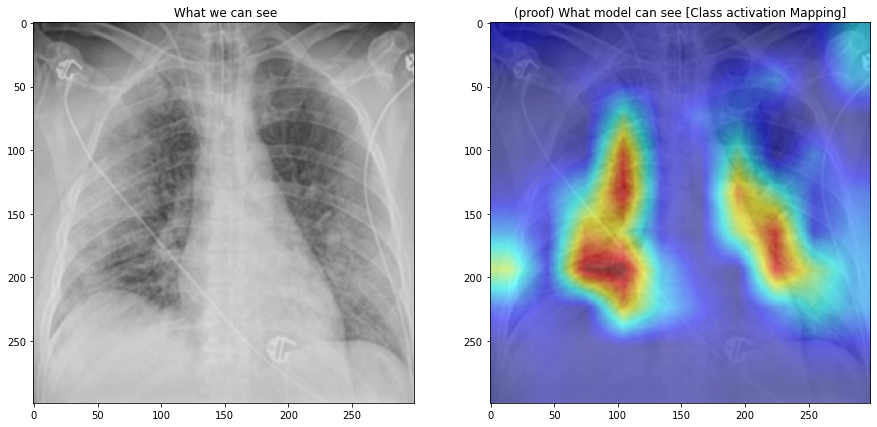

In [50]:
if dic['Covid'] == output:
    print("dude you have covid maintain social distance")
elif dic['Pneumonia'] == output:
    print("dude you have Pneumonia so just chill ")
else:
    print("Dude you are fine healthy af")
    

fig, ax = plt.subplots(1,2,figsize=(15,15))
img = cv2.imread(IMAGE_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cam = cv2.imread("./cam.jpg")
cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)
#fig.figsize(15,15)
ax[0].imshow(img)
ax[0].title.set_text(' What we can see')
ax[1].imshow(cam)
ax[1].title.set_text('(proof) What model can see [Class activation Mapping]')
#plt.imshow(cam)



In [51]:
gc.collect()

5044

# Testing model performance on test data

# predicting

In [20]:
if __name__ == '__main__':
  #  model = my_model(cfg['backbone'],3,pretrained = False)
    model = timm.create_model("resnet200d", pretrained=False)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 3)
    model.load_state_dict(torch.load('../input/covid-train-25-epochs-heavy-aug/Covid_classifier_resnet200d_fold0_validf10.9879976498710269.pth'))
    model = model.to(device)
    
    loss_fun = nn.CrossEntropyLoss()
    test_loader = test_dataloader(data)
    predictions , loss,accuracy,f1,precision,recall =  inference(test_loader,model,loss_fun,device)
    print(f'loss:{loss}, accuracy{accuracy}, f1_score{f1} , precision{precision},recall{recall}')

  0%|          | 0/965 [00:00<?, ?it/s]

loss:0.10996581732947726, accuracy0.9909968262193147, f1_score0.9801513517345098 , precision0.9891503234296438,recall0.9722867684680466


In [21]:
dic = { 
'Covid':0,
'Pneumonia':1,
'Normal':2}
pred_df = pd.DataFrame()
pred_df['Preds_one_hot'] = predictions 
pred_df['Predictions'] = 0
for i in range(pred_df.shape[0]):
    if dic['Covid'] == predictions[i]:
        pred_df['Predictions'][i] ='Covid'
    elif dic['Pneumonia'] == predictions[i]:
        pred_df['Predictions'][i] = 'Pneumonia'
    else:
        pred_df['Predictions'][i] = 'Normal'
        
pred_df = pd.concat([data,pred_df],axis =1).reset_index(drop = True)

In [22]:
pred_df

,Path,Class,Targets,Preds_one_hot,Predictions
0,../input/covid19-radiography-database/COVID-19...,Covid,0,0,Covid
1,../input/covid19-radiography-database/COVID-19...,Normal,2,2,Normal
2,../input/covid19-radiography-database/COVID-19...,Normal,2,2,Normal
3,../input/covid19-radiography-database/COVID-19...,Covid,0,0,Covid
4,../input/covid19-radiography-database/COVID-19...,Normal,2,2,Normal
...,...,...,...,...,...
15434,../input/covid19-radiography-database/COVID-19...,Normal,2,2,Normal
15435,../input/covid19-radiography-database/COVID-19...,Normal,2,2,Normal
15436,../input/covid19-radiography-database/COVID-19...,Covid,0,0,Covid
15437,../input/covid19-radiography-database/COVID-19...,Covid,0,0,Covid
